In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU, SimpleRNN
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import cross_val_score, KFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
import keras_tuner
from joblib import dump
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data_processed.csv')

# `Record Date Discreatized` is the continuous date
# treat `Fiscal Year` and `Record Date Discretized` as numbers and standardize them
# Other data include Month and Quarter as categories
# in order to discover some trends related to a specific Quarter or Month

numeric_features = ['Fiscal Year', 'Record Date Discretized']
categorical_features = ['Electronic Category ID', 'Channel Type ID', 'Tax Category ID', 'Fiscal Quarter Number', 'Calendar Quarter Number', 'Calendar Month Number']

data = data.drop(data.columns[0], axis=1)
data = data.drop(['Calendar Year', 'Calendar Day Number'], axis=1)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
X_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X = data.drop('Net Collections Amount', axis=1)
y = data['Net Collections Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.to_csv('model/X_train.csv', index=False)
X_test.to_csv('model/X_test.csv', index=False)
y_train.to_csv('model/y_train.csv', index=False)
y_test.to_csv('model/y_test.csv', index=False)

X_train = X_preprocessor.fit_transform(X_train)
X_test = X_preprocessor.transform(X_test)
# convert sparse matrix to numpy array
X_train = np.array(X_train.todense())
X_test = np.array(X_test.todense())

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [4]:
input_shape = (X_train.shape[1],)

# In my tests, LeakyReLU works better than normal relu
# Overfitting is very serious, maybe we can consider increasing the proportion of dropout
model = Sequential([
    Dense(128, input_shape=input_shape),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),
    
    Dense(512),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),
    
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),
    
    Dense(1)
])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.0001)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, 
                    validation_split=0.05,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=False)

dump(history.history, 'model_history.joblib')

train_loss, train_mae = model.evaluate(X_train, y_train)
test_loss, test_mae = model.evaluate(X_test, y_test)


print(f'Test MAE: {test_mae}')
print(f'Train MAE: {train_mae}')


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2514/2514 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - loss: 0.5337 - mae: 0.1905
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.2711 - mae: 0.1821
Test MAE: 0.1998300999403
Train MAE: 0.19066426157951355


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


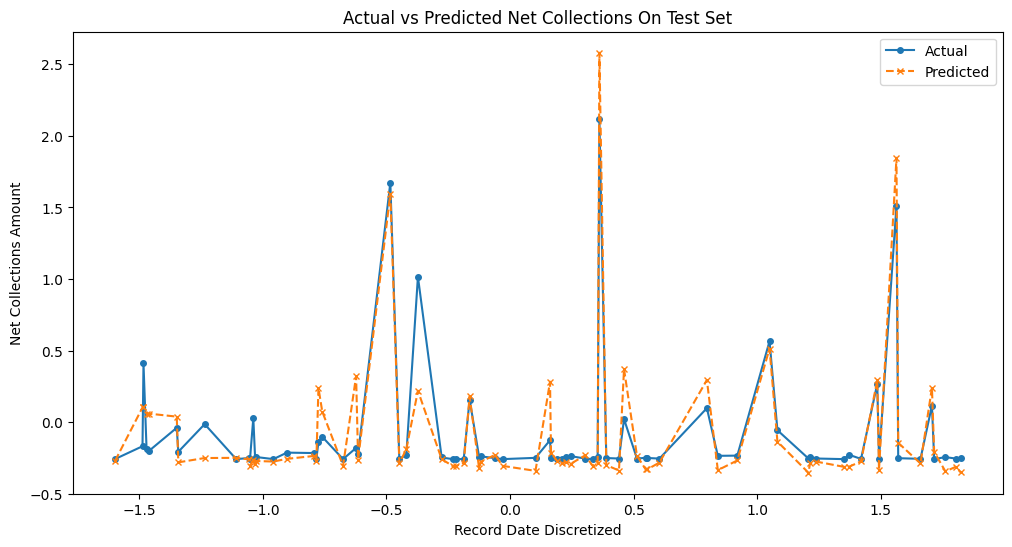

In [5]:

# dump preprocessor and scaler
dump(X_preprocessor, 'model/X_preprocessor.joblib')
dump(y_scaler, 'model/y_scaler.joblib')

# Draw the predicted values and actual values of some data in the test set
SIZE = 75

yhat_test = model.predict(X_test[:SIZE])
record_dates = X_test[:SIZE, 1]

results = pd.DataFrame({
    'Record Date Discretized': record_dates,
    'Actual': y_test[:SIZE, 0],
    'Predicted': yhat_test[:SIZE, 0]
})

results_sorted = results.sort_values('Record Date Discretized')

plt.figure(figsize=(12, 6))
plt.plot(results_sorted['Record Date Discretized'], results_sorted['Actual'], label='Actual', marker='o', linestyle='-', markersize=4)
plt.plot(results_sorted['Record Date Discretized'], results_sorted['Predicted'], label='Predicted', marker='x', linestyle='--', markersize=4)

plt.title('Actual vs Predicted Net Collections On Test Set')
plt.xlabel('Record Date Discretized')
plt.ylabel('Net Collections Amount')
plt.legend()
plt.show()

In [57]:
# Load saved models and preprocessors to predict new data
X_preprocessor = load('model/X_preprocessor.joblib')
y_scaler = load('model/y_scaler.joblib')
model = load_model('model/best_model.keras')
X_train_orig = pd.read_csv('model/X_train.csv')
X_test_orig = pd.read_csv('model/X_test.csv')
y_train_orig = pd.read_csv('model/y_train.csv')
y_test_orig = pd.read_csv('model/y_test.csv')
history = load('model/model_history.joblib')

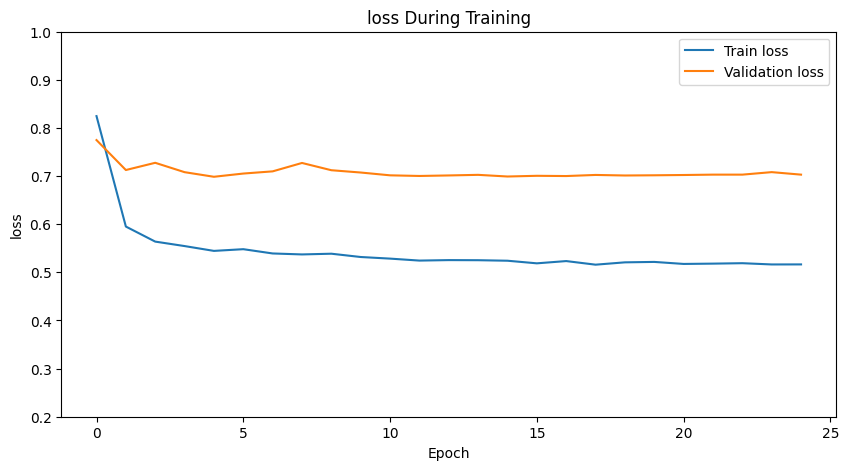

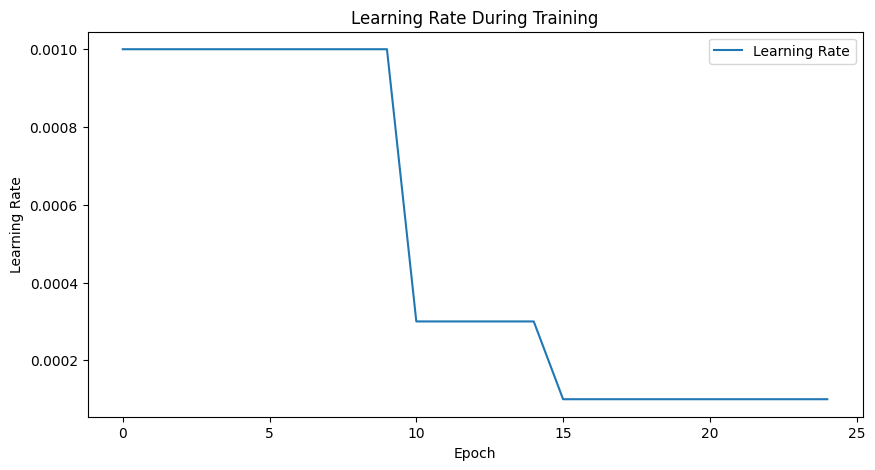

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('loss During Training')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.2, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate During Training')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

2/2 [==============================] - 0s 1ms/step


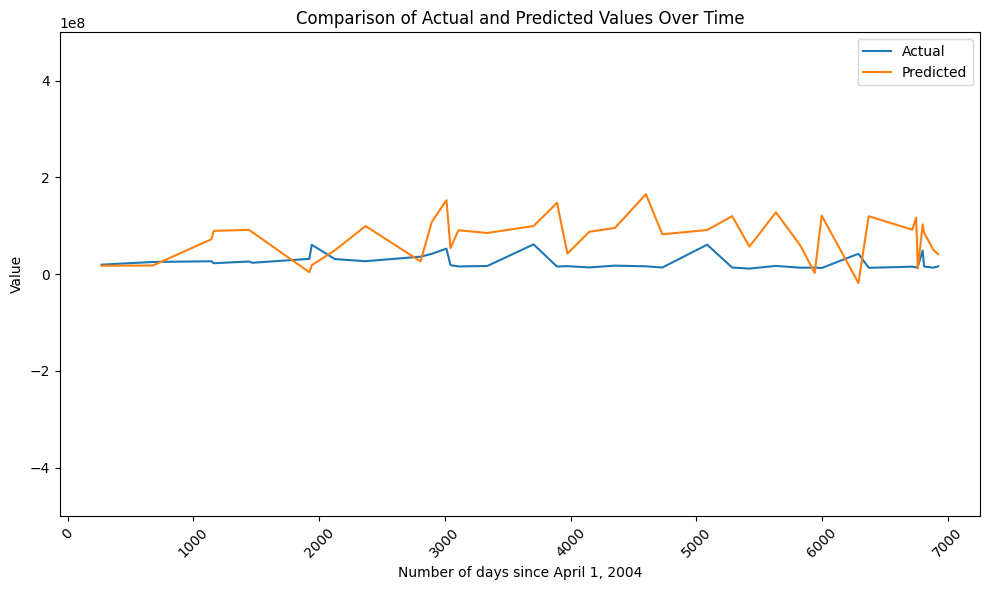

In [76]:
X_selected = X_test_orig[(X_test_orig['Electronic Category ID'] == 1) & (X_test_orig['Channel Type ID'] == 1) & (X_test_orig['Tax Category ID'] == 1)]
X_selected_processed = np.array(X_preprocessor.transform(X_selected).todense())
y_selected = y_test_orig.loc[X_selected.index]['Net Collections Amount']
yhat_selected = model.predict(X_selected_processed)
yhat_selected = y_scaler.inverse_transform(yhat_selected)
dates = X_selected['Record Date Discretized']
df_plot = pd.DataFrame({
    'Date': dates,
    'Actual': y_selected,
    'Predicted': yhat_selected.flatten()
})
df_plot_sorted = df_plot.sort_values(by='Date')
plt.figure(figsize=(10, 6))

plt.plot(df_plot_sorted['Date'], df_plot_sorted['Actual'], label='Actual')
plt.plot(df_plot_sorted['Date'], df_plot_sorted['Predicted'], label='Predicted')
plt.ylim([-5e8, 5e8])
plt.title('Comparison of Actual and Predicted Values Over Time')
plt.xlabel('Number of days since April 1, 2004')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
df = pd.read_csv('USGovtRevCollect_20041001_20231227.csv')
electronic_dict = pd.Series(df['Electronic Category ID'].values, index=df['Electronic Category Description']).to_dict()
channel_dict = pd.Series(df['Channel Type ID'].values, index=df['Channel Type Description']).to_dict()
tax_dict = pd.Series(df['Tax Category ID'].values, index=df['Tax Category Description']).to_dict()
base_date = df['Record Date'].min()

def evaluate(electronic_type, channel_type, tax_type, fiscal_year, fiscal_quarter, record_date):
    data = pd.DataFrame({})
    
    if electronic_type not in electronic_dict: return None
    else: data['Electronic Category ID'] = [electronic_dict[electronic_type]]
        
    if channel_type not in channel_dict: return None
    else: data['Channel Type ID'] = [channel_dict[channel_type]]
        
    if tax_type not in tax_dict: return None
    else: data['Tax Category ID'] = [tax_dict[tax_type]]
    
    data['Fiscal Year'] = [fiscal_year]
    data['Fiscal Quarter Number'] = [fiscal_quarter]
    
    try:
        date_obj = datetime.strptime(record_date, '%Y-%m-%d')
        data['Calendar Quarter Number'] = [(date_obj.month - 1) // 3 + 1]
        data['Calendar Month Number'] = [date_obj.month]
        basedate_obj = datetime.strptime(base_date, '%Y-%m-%d')
        data['Record Date Discretized'] = [(date_obj - basedate_obj).days]
    except ValueError:
        return None

    X = X_preprocessor.transform(data)
    X = np.array(X.todense())
    prediction = model.predict(X)
    prediction = y_scaler.inverse_transform(prediction)
    return prediction

In [45]:
# electronic_type = {
#     'Fully Electronic - All': 1,
#     'Fully Electronic - FS': 2,
#     'Electronic Settlement': 3,
#     'Non-Electronic': 4,
# }
# channel_type = {
#     'Over-the-Counter (OTC)': 1,
#     'Mail': 2,
#     'Internet': 3,
#     'Bank': 5,
#     'Other': 7,
# }
# tax_type = {
#     'Non-Tax': 1,
#     'IRS Non-Tax': 2,
#     'IRS Tax': 3
# }

result = evaluate(
    electronic_type='Fully Electronic - All',
    channel_type='Internet',
    tax_type='IRS Tax',
    fiscal_year=2025,
    fiscal_quarter=2,
    record_date='2025-2-20'
)
print('\nPredicted Net Collections Amount =', result[0][0])

1/1 [==============================] - 0s 15ms/step

Predicted Net Collections Amount = 17298844000.0
